# Cahn-Hilliard Example

This example demonstrates how to use PyMKS to solve the Cahn-Hilliard equation. The first section provides some background information about the Cahn-Hilliard equation as well as details about calibrating and validating the MKS model. The example demonstrates how to generate sample data, calibrate the influence coefficients and then pick an appropriate number of local states when state space is continuous. The MKS model and a spectral solution of the Cahn-Hilliard equation are compared on a larger test microstructure over multiple time steps.

### Cahn-Hilliard Equation

The Cahn-Hilliard equation is used to simulate microstructure evolution during spinodial decomposition and has the following form,

$$ \dot{\phi} = \nabla^2 \left( \phi^3 - \phi \right) - \gamma \nabla^4 \phi $$

where $\phi$ is a conserved ordered parameter and $\sqrt{\gamma}$ represents the width of the interface. In this example, the Cahn-Hilliard equation is solved using a semi-implicit spectral scheme with periodic boundary conditions, see  [Chang and Rutenberg](http://dx.doi.org/10.1103/PhysRevE.72.055701) for more details.

In [1]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy
import matplotlib.pyplot as plt
from toolz.curried import pipe, map
from dask.multiprocessing import get
from dask_ml.model_selection import train_test_split
from pymks.fmks.data.cahn_hilliard import generate
from pymks.fmks.bases.primitive import PrimitiveTransformer, redundancy
from pymks.fmks.localization import LocalizationRegressor, flatten, ReshapeTransformer

/nix/store/b6pcn34yqrnnah35661qsv3x87ichad2-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/__init__.py:465: UserWarning: matplotlibrc text.usetex option can not be used unless TeX is installed on your system
  warnings.warn('matplotlibrc text.usetex option can not be used unless '
/nix/store/b6pcn34yqrnnah35661qsv3x87ichad2-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/__init__.py:473: UserWarning: matplotlibrc text.usetex can not be used with *Agg backend unless dvipng-1.6 or later is installed on your system
  'your system' % dvipng_req)
/nix/store/b6pcn34yqrnnah35661qsv3x87ichad2-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/__init__.py:480: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-8.60 or later is installed on your system
  % gs_req)


## Modeling with MKS

In this example the MKS equation will be used to predict microstructure at the next time step using 

$$p[s, 1] = \sum_{r=0}^{S-1} \alpha[l, r, 1] \sum_{l=0}^{L-1} m[l, s - r, 0] + ...$$

where $p[s, n + 1]$ is the concentration field at location $s$ and at time $n + 1$, $r$ is the convolution dummy variable and $l$ indicates the local states varable. $\alpha[l, r, n]$ are the influence coefficients and $m[l, r, 0]$ the microstructure function given to the model. $S$ is the total discretized volume and $L$ is the total number of local states `n_states` choosen to use.

The model will march forward in time by recursively replacing discretizing $p[s, n]$ and substituing it back for $m[l, s - r, n]$.

### Calibration Datasets

Unlike the elastostatic examples, the microstructure (concentration field) for this simulation doesn't have discrete phases. The microstructure is a continuous field that can have a range of values which can change over time, therefore the first order influence coefficients cannot be calibrated with delta microstructures. Instead, a large number of simulations with random initial conditions are used to calibrate the first order influence coefficients using linear regression.

The function `generate` from `pymks.fmks.data.cahn_hilliard` provides an interface to generate calibration datasets for the influence coefficients. To use `generate`, we need to set the number of samples and domain size we want to use to calibrate the influence coefficients using `shape`, how we would like to `chunk` the data in Dask and the time step using `delta_t`.

In [2]:
numpy.random.seed(99)

%time data = generate(shape=(400, 41, 41), chunks=(40, 41, 41), delta_t=1e-2)
%time _ = data[1].compute()


CPU times: user 7.6 ms, sys: 0 ns, total: 7.6 ms
Wall time: 7.28 ms
CPU times: user 602 ms, sys: 30.3 ms, total: 632 ms
Wall time: 85.6 ms


The function `generate` generates 400 random microstructures, `X`, and the associated updated microstructures, `y`, after one time step. The following cell plots one of these microstructures along with its update.

/nix/store/b6pcn34yqrnnah35661qsv3x87ichad2-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


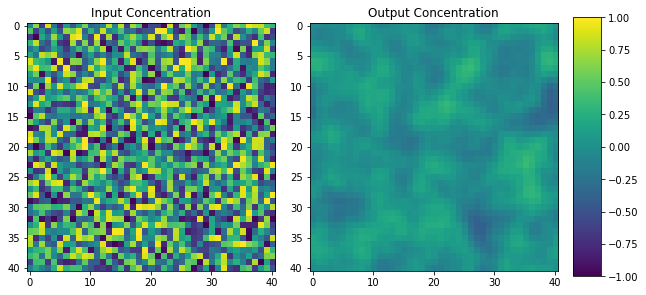

In [3]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

def plot(X, y):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
    ax0.imshow(X, interpolation='none', vmin=-1, vmax=1)
    ax0.set_title("Input Concentration")
    im = ax1.imshow(y, interpolation='none', vmin=-1, vmax=1)
    ax1.set_title("Output Concentration")
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1.0, 0.05, 0.05, 0.9])
    cbar_ax.yaxis.set_offset_position('right')
    fig.colorbar(im, cax=cbar_ax)
    _ = plt.tight_layout()

X = data[0][0].compute(num_workers=4, get=get)
y = data[1][0].compute(num_workers=4, get=get)
plot(X, y)
    

### Calibrate Influence Coefficients

As mentioned above, the microstructures (concentration fields) does not have discrete phases. This leaves the number of local states in local state space as a free hyperparameter. In previous work it has been shown that, as you increase the number of local states, the accuracy of MKS model increases (see [Fast et al.](http://dx.doi.org/10.1016/j.actamat.2010.10.008)), but, as the number of local states increases, the difference in accuracy decreases. Some work needs to be done in order to find the practical number of local states that we will use. 

### Optimizing the Number of Local States

Let's split the calibrate dataset into test and training datasets. The function `train_test_split` for the machine learning Python module [dask_ml](http://dask-ml.readthedocs.io/en/latest/index.html) provides a convenient interface to do this. 80% of the dataset will be used for training and the remaining 20% will be used for testing by setting `test_size` equal to 0.2.

In [4]:
X, y = data
X_train, X_test, y_train, y_test = train_test_split(flatten(X), flatten(y), test_size=0.2)
print(type(X_train.compute()))
print(y_test)

<class 'numpy.ndarray'>
dask.array<concatenate, shape=(80, 1681), dtype=float64, chunksize=(8, 1681)>


We are now going to calibrate the influence coefficients while varying the number of local states from 2 up to 20. Each of these models will then predict the evolution of the concentration fields. Mean square error will be used to compare the results with the testing dataset to evaluate how the MKS model's performance changes as we change the number of local states.  

First we need to import the class `LocalizationModel` from `pymks`.

In [5]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    ReshapeTransformer(shape=X.shape),
    PrimitiveTransformer(n_state=5, min_=-1, max_=1.0),
    LocalizationRegressor(redundancy_func=redundancy)
)
    

In [6]:
%time model.fit(X_train, y_train)

CPU times: user 1.24 s, sys: 138 ms, total: 1.38 s
Wall time: 499 ms


Pipeline(memory=None,
     steps=[('reshapetransformer', ReshapeTransformer(shape=(400, 41, 41))), ('primitivetransformer', PrimitiveTransformer(max_=1.0, min_=-1, n_state=5)), ('localizationregressor', LocalizationRegressor(redundancy_func=<function redundancy at 0x7f4b7eb65950>))])

In [7]:
y_pred = model.predict(X_test)

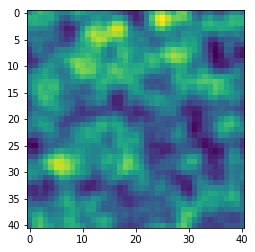

In [8]:
plt.imshow(ReshapeTransformer(X.shape).transform(y_pred)[0])

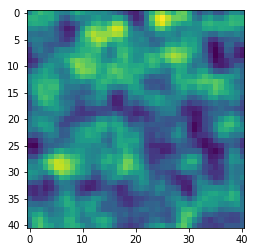

In [9]:
plt.imshow(ReshapeTransformer(X.shape).transform(y_test)[0])

Next we will calibrate the influence coefficients while varying the number of local states and compute the mean squared error. The following demonstrates how to use scikit-learn's `GridSearchCV` to optimize `n_states` as a hyperparameter. Of course, the best fit is always with a larger value of `n_states`. Increasing this parameter does not overfit the data.

In [10]:
X_train.shape
X_train.chunks
y_train.chunks

((32, 32, 32, 32, 32, 32, 32, 32, 32, 32), (1681,))

In [12]:
#PYTEST_VALIDATE_IGNORE_OUTPUT
from dask_ml.model_selection import GridSearchCV
from distributed import Client
Client()

params = {'primitivetransformer__n_state': range(2, 10)}
gs = GridSearchCV(model, params, cv=5, n_jobs=2)
%time gs.fit(X_train, y_train)


CPU times: user 1.24 s, sys: 345 ms, total: 1.59 s
Wall time: 11.9 s


GridSearchCV(cache_cv=True, cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('reshapetransformer', ReshapeTransformer(shape=(400, 41, 41))), ('primitivetransformer', PrimitiveTransformer(max_=1.0, min_=-1, n_state=5)), ('localizationregressor', LocalizationRegressor(redundancy_func=<function redundancy at 0x7f4b7eb65950>))]),
       iid=True, n_jobs=2,
       param_grid={'primitivetransformer__n_state': range(2, 10)},
       refit=True, return_train_score='warn', scheduler=None, scoring=None)

In [26]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

print(gs.best_estimator_)
print(gs.score(X_test, y_test))


Pipeline(memory=None,
     steps=[('reshapetransformer', ReshapeTransformer(shape=(400, 41, 41))), ('primitivetransformer', PrimitiveTransformer(max_=1.0, min_=-1, n_state=10)), ('localizationregressor', LocalizationRegressor(redundancy_func=<function redundancy at 0x7f43f7f9f268>))])
0.9999990800421993


In [14]:
gs.cv_results_

/nix/store/i47wyb7xqjnki251ibwzsxmd8kl5gp23-python3.6-scikit-learn-0.19.1/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in sklearn 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/nix/store/i47wyb7xqjnki251ibwzsxmd8kl5gp23-python3.6-scikit-learn-0.19.1/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in sklearn 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/nix/store/i47wyb7xqjnki251ibwzsxmd8kl5gp23-python3.6-scikit-learn-0.19.1/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available 

{'mean_fit_time': array([197.83812834, 244.8390141 , 303.02946453, 384.60557427,
        442.50597781, 492.04193634, 553.85710888, 624.16096985,
        785.37664841]),
 'mean_score_time': array([0.1300902 , 0.13265196, 0.14638559, 0.18305889, 0.21375183,
        0.21759283, 0.2194383 , 0.2498004 , 0.2681111 ]),
 'mean_test_score': array([0.99952481, 0.99952265, 0.99991841, 0.99997563, 0.9999903 ,
        0.9999954 , 0.99999754, 0.99999856, 0.99999911]),
 'mean_train_score': array([0.99953389, 0.9995357 , 0.99992122, 0.99997667, 0.99999078,
        0.99999567, 0.9999977 , 0.99999866, 0.99999918]),
 'param_primitivetransformer__n_state': masked_array(data=[2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'primitivetransformer__n_state': 2},
  {'primitivetransformer__n_state': 3},
  {'primitivetransformer__n_state': 4},
  {'primitivetransfor

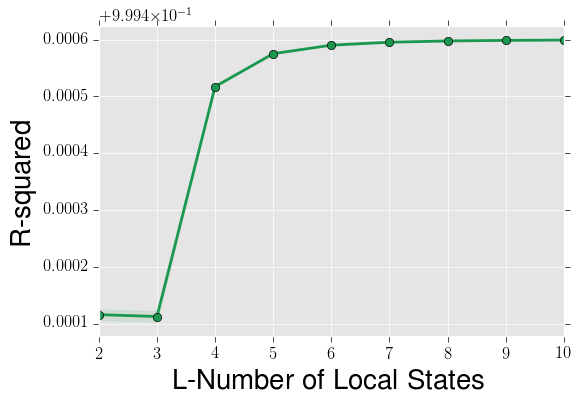

In [20]:
from pymks.tools import draw_gridscores

draw_gridscores(gs.grid_scores_, 'n_states',
                score_label='R-squared', param_label='L-Number of Local States')


As expected, the accuracy of the MKS model monotonically increases, as we increase `n_states`, but accuracy doesn't improve significantly as `n_states` gets larger than signal digits. 

In order to save on computation costs, let's set (calibrate) the influence coefficients with `n_states` equal to 6, but realize that, if we need slightly more accuracy, the value can be increased.

In [21]:
model = MKSLocalizationModel(basis=PrimitiveBasis(6, [-1, 1]))
model.fit(X, y)


Here are the first 4 influence coefficients. 

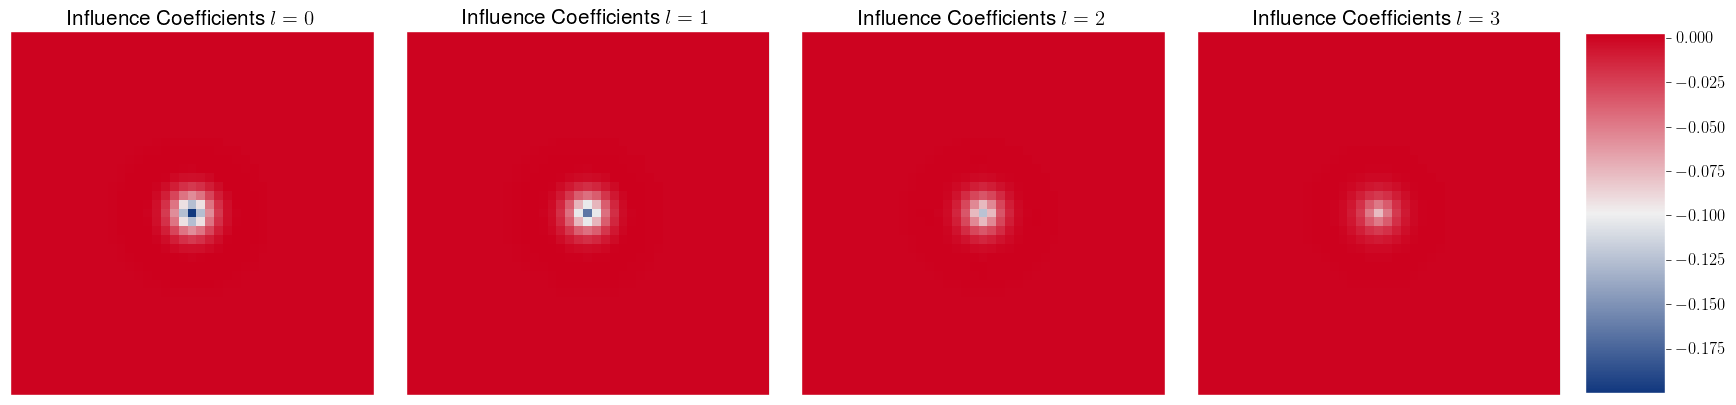

In [22]:
from pymks.tools import draw_coeff

draw_coeff(model.coef_[...,:4])


### Predict Microstructure Evolution

With the calibrated influence coefficients, we are ready to predict the evolution of a concentration field. In order to do this, we need to have the Cahn-Hilliard simulation and the MKS model start with the same initial concentration `phi0` and evolve in time. In order to do the Cahn-Hilliard simulation, we need an instance of the class `CahnHilliardSimulation`.

In [23]:
from pymks.datasets.cahn_hilliard_simulation import CahnHilliardSimulation
np.random.seed(191)

phi0 = np.random.normal(0, 1e-9, (1, n, n))
ch_sim = CahnHilliardSimulation(dt=dt)
phi_sim = phi0.copy()
phi_pred = phi0.copy()


In order to move forward in time, we need to feed the concentration back into the Cahn-Hilliard simulation and the MKS model.

In [24]:
time_steps = 10

for ii in range(time_steps):
    ch_sim.run(phi_sim)
    phi_sim = ch_sim.response
    phi_pred = model.predict(phi_pred)


Let's take a look at the concentration fields.

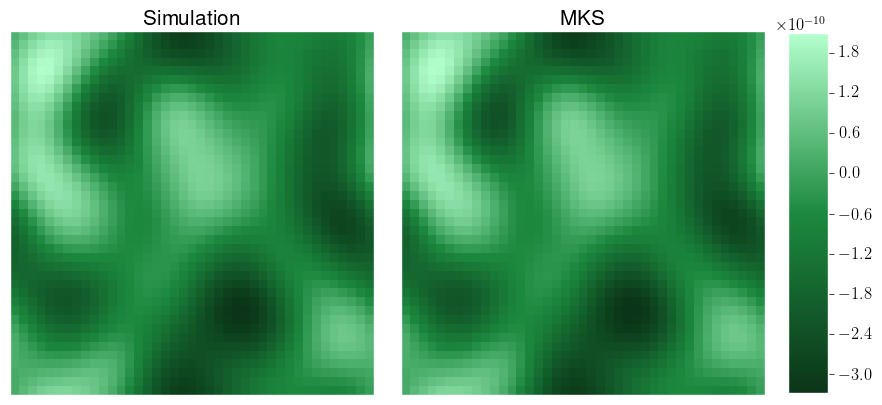

In [25]:
from pymks.tools import draw_concentrations_compare

draw_concentrations((phi_sim[0], phi_pred[0]), labels=('Simulation', 'MKS'))


The MKS model was able to capture the microstructure evolution with 6 local states. 

## Resizing the Coefficients to use on Larger Systems 

Now let's try and predict a larger simulation by resizing the coefficients and provide a larger initial concentratio field.

In [26]:
m = 3 * n
model.resize_coeff((m, m))

phi0 = np.random.normal(0, 1e-9, (1, m, m))
phi_sim = phi0.copy()
phi_pred = phi0.copy()


Once again we are going to march forward in time by feeding the concentration fields back into the Cahn-Hilliard simulation and the MKS model. 

In [27]:
for ii in range(1000):
    ch_sim.run(phi_sim)
    phi_sim = ch_sim.response
    phi_pred = model.predict(phi_pred)


Let's take a look at the results.

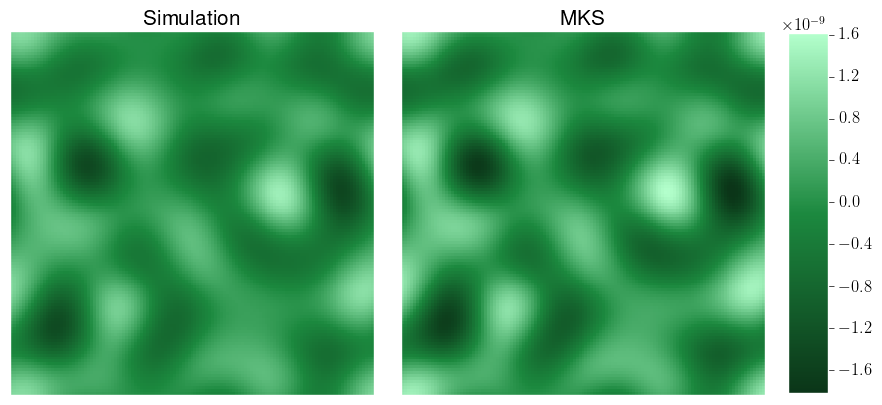

In [28]:
from pymks.tools import draw_concentrations_compare

draw_concentrations_compare((phi_sim[0], phi_pred[0]), labels=('Simulation', 'MKS'))


The MKS model with resized influence coefficients was able to reasonably predict the structure evolution for a larger concentration field. 